```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is a prototype for all required parts of a realistic simulation

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from matplotlib import animation, rc, colors, colorbar
from matplotlib import pyplot as plt

from IPython.display import display
from IPython.display import Video

#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import FBL, CTCS, KP07, CDKLM16, PlotHelper, Common, WindStress, IPythonMagic, OceanographicUtilities, NetCDFInitialization

In [3]:
%setup_logging -o lofoten_sim.log
%cuda_context_handler gpu_ctx

Console logger using level INFO
File logger disabled
Python version 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Registering gpu_ctx in user workspace
PyCUDA version 2019.1.2
CUDA version (10, 1, 0)
Driver version 10010
Using 'Tesla P100-PCIE-12GB' GPU
Created context handle <94152279938400>


In [4]:
#Set this to false before comitting to only get images
create_movie = False
movie_frames = 200 
download_data = True

In [5]:
#case = 1 # Open waters in the Norwegian Sea
case = 2 # Lofoten
#case = 3 # The Norwegian Coast

casename = 'norwegian_sea_'

if case == 2:
    casename = 'lofoten_'
    
if case == 3:
    casename = 'complete_coast_'
    
folder = casename+datetime.datetime.now().strftime("%Y_%m_%d")

# Overrule the above folder name:
#folder = 'norwegian_sea_2019_10_09'
#folder = 'lofoten_2019_10_07'
#folder = 'complete_coast_2019_10_09'

assert(folder.startswith(casename)), 'folder does not start with casename!'

os.makedirs(folder, exist_ok=True)
print(folder)

lofoten_2019_11_22


In [6]:
nordic4km_url = 'http://thredds.met.no/thredds/dodsC/fou-hi/nordic4km-1h/Nordic-4km_SURF_1h_avg_00.nc'
norkyst800_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

source_url = norkyst800_url

In [7]:
if (download_data):
    filename = os.path.abspath(os.path.basename(source_url))
    
    if (os.path.isfile(filename)):
        source_url = filename
    
    else:
        import requests
        download_url = source_url.replace("dodsC", "fileServer")

        req = requests.get(download_url, stream = True)
        filesize = int(req.headers.get('content-length'))

        progress = Common.ProgressPrinter()
        pp = display(progress.getPrintString(0),display_id=True)

        print("Downloading data to local file (" + str(filesize // (1024*1024)) + " MB)")
        with open(filename, "wb") as outfile:
            for chunk in req.iter_content(chunk_size = 10*1024*1024):
                if chunk:
                    outfile.write(chunk)
                    pp.update(progress.getPrintString(outfile.tell() / filesize))

        source_url = filename
        
print("Source is : " + source_url)

Source is : /home/andreb/projects/gpu-ocean/gpu_ocean/demos/realisticSimulations/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc


In [8]:
##### 
case2_x0 = 1650
case2_x1 = int(case2_x0 + 100)
case2_y0 = 525
case2_y1 = int(case2_y0 + 50)

#x0 = 1650
#x1 = int(x0 + 100)
#y0 = 450
#y1 = int(y0 + 200)

case1_x0 = 900
case1_x1 = 1400
case1_y0 = 600
case1_y1 = 875


case3_x0 = 25
case3_x1 = 2575
case3_y0 = 25
case3_y1 = 875

## Select case

x0 = case1_x0
x1 = case1_x1
y0 = case1_y0
y1 = case1_y1

if case == 2:
    x0 = case2_x0
    x1 = case2_x1
    y0 = case2_y0
    y1 = case2_y1
    print('using the Lofoten case')

elif case == 3:
    x0 = case3_x0
    x1 = case3_x1
    y0 = case3_y0
    y1 = case3_y1
    print('using the complete coast case')

else:
    print('using Norwegian Sea area')


using the Lofoten case


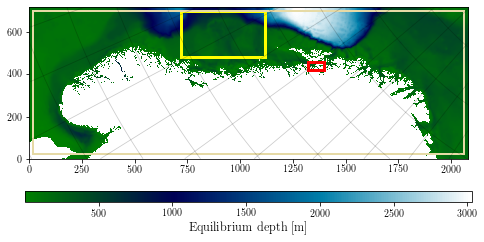

In [9]:
def plotMapAndCases():
    try:
        ncfile = Dataset(source_url)
        H_full = np.array(ncfile.variables['h'])
        angle = np.array(ncfile.variables['angle'])
        lat = np.array(ncfile.variables["lat"])
        lon = np.array(ncfile.variables["lon"])
    except Exception as e:
        raise e

    finally:
        ncfile.close()

        land_value = H_full.min()
    (full_ny, full_nx) = H_full.shape

    # Makes sure axis are in km (assuming equidistant 800x800m grid)
    extent=np.array([0, full_nx*0.8, 0, full_ny*0.8])


    fig = plt.figure(figsize=(8,4))

    # Land and bathymetry
    land = np.ma.masked_where(H_full == land_value, H_full)
    im = plt.imshow(land, interpolation="None", origin='lower', cmap='ocean',
               extent=extent)

    cbar = fig.colorbar(im, orientation='horizontal', aspect=40)
    cbar.set_label('Equilibrium depth [m]', size=12.5)


    # Case boxes
    fig.gca().fill(np.array([case1_x0, case1_x0, case1_x1, case1_x1])*0.8, 
                   np.array([case1_y0, case1_y1, case1_y1, case1_y0])*0.8, 
                   fill=False, linestyle='-', linewidth=3, color='yellow')
    fig.gca().fill(np.array([case2_x0, case2_x0, case2_x1, case2_x1])*0.8, 
                   np.array([case2_y0, case2_y1, case2_y1, case2_y0])*0.8, 
                   fill=False, linestyle='-', linewidth=3, color='red')

    # Save without north arrow
    plt.savefig(os.path.join(folder, 'caseLocationsInNorway.pdf'))
    plt.savefig(os.path.join(folder, 'caseLocationsInNorway.png'))

    plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN.pdf'))
    plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN.png'))

    fig.gca().fill(np.array([case3_x0, case3_x0, case3_x1, case3_x1])*0.8, 
                   np.array([case3_y0, case3_y1, case3_y1, case3_y0])*0.8, 
                   fill=False, linestyle='-', linewidth=2, color='xkcd:beige')

    plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases.pdf'))
    plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases.png'))

    plt.contour(lon, levels = np.arange(0, 40, 4), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
    plt.contour(lat, levels = np.arange(56,77, 2), extent=extent, colors='k', alpha=0.2, linewidths=0.8)

    plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases_latlon.pdf'))
    plt.savefig(os.path.join(folder, 'caseLocationsInNorway_withN_3cases_latlon.png'))

plotMapAndCases()

In [24]:
def runMidpointsToIntersections():

    try:
        ncfile = Dataset(source_url)
        H_m = ncfile.variables['h'][y0-1:y1+1, x0-1:x1+1]
        eta = ncfile.variables['zeta'][0, y0-1:y1+1, x0-1:x1+1]
        print("Read Hm as " + str(H_m.shape))

    except Exception as e:
        raise e
    finally:
        ncfile.close()

    #Apply land mask
    land_value = 5.0
    from scipy.ndimage.morphology import binary_erosion
    H_m = np.ma.array(H_m, mask =eta.mask)

    importlib.reload(OceanographicUtilities)
    H_i, convergence = OceanographicUtilities.midpointsToIntersections(H_m, iterations=21, tolerance=0, land_value=5.0, compute_convergence=True)
    H_m_new = OceanographicUtilities.intersectionsToMidpoints(H_i)
    
    return H_i, H_m_new, H_m[1:-1,1:-1], convergence
H_i, H_m, H_m_new, convergence = runMidpointsToIntersections()

Read Hm as (52, 102)


In [25]:
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1']) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':']) +
                       #cycler('markersize', [15, 15, 15, 15, 15, 15]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k']) )

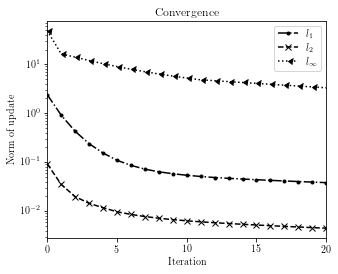

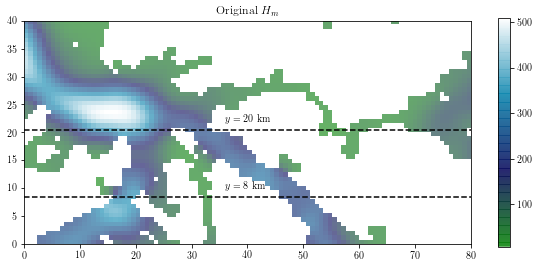

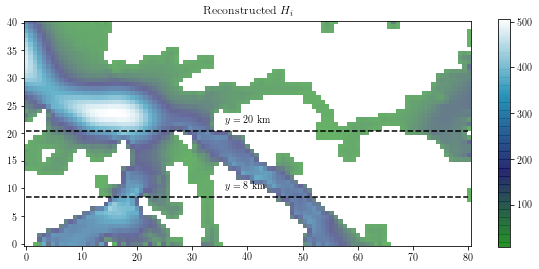

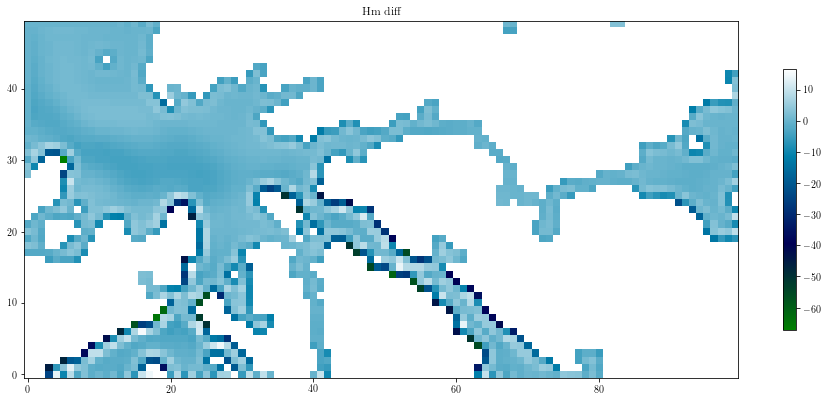

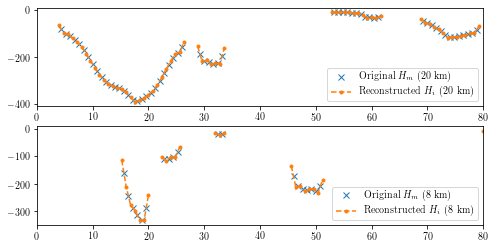

In [27]:
def plotMidpointsToIntersections(H_i, H_m, H_m_new, convergence):

    nx = x1-x0
    ny = y1-y0
    dx = 0.8#800.0/1000
    dy = 0.8#800.0/1000
    
    #lines = [85, 115]
    lines = [25, 10]
    
    tex_labels = {'l_1': 'l_1', 'l_2': 'l_2', 'l_inf': 'l_{\infty}'}
        
    fig = plt.figure(figsize=(5,4))
    setBwStyles(fig.gca())
    for l in ['l_1', 'l_2', 'l_inf']:
        plt.semilogy(np.linspace(0, len(convergence[l])-1, len(convergence[l])), convergence[l], label="$" + tex_labels[l] + "$")
    plt.xlim([0, 20])
    plt.xticks([0, 5, 10, 15, 20])
    plt.ylabel('Norm of update')
    plt.xlabel('Iteration')
    plt.title("Convergence")
    plt.legend()
    plt.savefig("bathymetry_convergence.pdf")

    fig = plt.figure(figsize=(10,6))
    plt.imshow(H_m_new, interpolation="None", origin='lower', cmap='ocean', extent=[0, nx*dx, 0, ny*dy], alpha=0.6)
    for line in lines:
        plt.annotate("$y = {:.0f}$ km".format((line+0.5)*dy), (45*dx, (line+2.5)*dy))
        plt.plot([0, nx*dx], [(line+0.5)*dy, (line+0.5)*dy], 'k--')
    plt.colorbar(shrink=0.7)
    plt.title("Original $H_m$")
    plt.savefig("original_Hm.pdf")

    fig = plt.figure(figsize=(10,6))
    plt.imshow(H_i, interpolation="None", origin='lower', cmap='ocean', extent=[-0.5*dx, (nx+0.5)*dx, -0.5*dy, (ny+0.5)*dy], alpha=0.6)
    for line in lines:
        plt.annotate("$y = {:.0f}$ km".format((line+0.5)*dy), (45*dx, (line+2.5)*dy))
        plt.plot([0, nx*dx], [(line+0.5)*dy, (line+0.5)*dy], 'k--')
    plt.colorbar(shrink=0.7)
    plt.title("Reconstructed $H_i$")
    plt.savefig("reconstructed_Hi.pdf")
    
    fig = plt.figure(figsize=(16,8))
    plt.imshow(H_m-H_m_new, interpolation="None", origin='lower', cmap='ocean')
    plt.colorbar(shrink=0.6)
    plt.title("Hm diff")
    
    fig = plt.figure(figsize=(8,4))
    for i, j in enumerate(lines):
        plt.subplot(2,1,i+1)
        #plt.title("$y = {:.0f}$ km".format((j+0.5)*dy))
        plt.plot(np.linspace(0.5*dx, (nx-0.5)*dx, nx), -H_m[j,:], 'x', label="Original $H_m$ ({:.0f} km)".format((j+0.5)*dy))
        plt.plot(np.linspace(0, nx*dx, nx+1), -0.5*(H_i[j,:]+H_i[j+1,:]), '.--', label="Reconstructed $H_i$ ({:.0f} km)".format((j+0.5)*dy))
        #plt.plot(H_m_new[i,:], 'x', label='$R_' + str(i) + "$")
        plt.legend(loc='lower right')
        plt.xlim([0, nx*dx])
    plt.savefig("bathymetry_reconstruction.pdf")
    
plotMidpointsToIntersections(H_i, H_m, H_m_new, convergence)

In [11]:
ic = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1)

Range eta0 [0.92100006, -1.588]
Range hu0 [442.2672013119142, -363.95278391577443]
Range hv0 [333.3361798531379, -275.6964227637318]
Range H [3024.495759960227, 5.0]
Range angle [1.2413501739501953, 0.5711770057678223]
t0 2019-07-16 00:00:00
Timesteps [0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0
 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0]


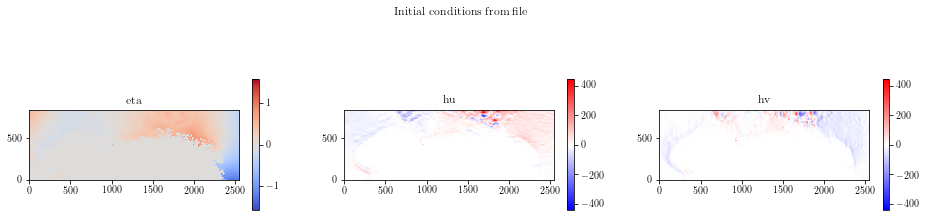

In [12]:
def plotInitialConditions():
    etamax = np.max(np.abs(ic['eta0']))
    uvmax = max(np.max(np.abs(ic['hu0'])), np.max(np.abs(ic['hv0'])))
    
    plt.figure(figsize=(16, 4))
    plt.suptitle("Initial conditions from file")

    plt.subplot(1,3,1)
    plt.title("eta")
    plt.imshow(ic['eta0'], interpolation="None", origin='lower', cmap='coolwarm', vmin=-etamax, vmax=etamax)
    plt.colorbar(shrink=0.6)

    plt.subplot(1,3,2)
    plt.title("hu")
    plt.imshow(ic['hu0'], interpolation="None", origin='lower', cmap='bwr', vmin=-uvmax, vmax=uvmax)
    plt.colorbar(shrink=0.6)

    plt.subplot(1,3,3)
    plt.title("hv")
    plt.imshow(ic['hv0'], interpolation="None", origin='lower', cmap='bwr', vmin=-uvmax, vmax=uvmax)
    plt.colorbar(shrink=0.6)

    for var in ['eta0', 'hu0', 'hv0', 'H', 'angle']:
        print("Range", var, [np.max(ic[var]), np.min(ic[var])])
    
    print("t0", datetime.datetime.utcfromtimestamp(ic['t0']))
    print("Timesteps", ic['boundary_conditions_data'].t/3600)

plotInitialConditions()

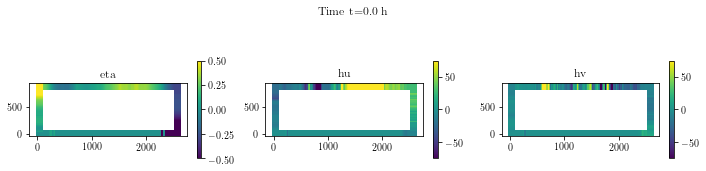

In [13]:
def bcAnimation(create_movie=True, **kwargs):
    nx = x1-x0
    ny = y1-y0
    x_north = np.linspace(x0, x1, nx)
    y_north = np.linspace(y1, y1, nx)

    x_south = np.linspace(x0, x1, nx)
    y_south = np.linspace(y0, y0, nx)

    x_east = np.linspace(x1, x1, ny)
    y_east = np.linspace(y0, y1, ny)

    x_west = np.linspace(x0, x0, ny)
    y_west = np.linspace(y0, y1, ny)
    
    fig = plt.figure(figsize=(12,3))
    
    sc = [None]*12
    ax = [None]*3
    
    bc_data = ic['boundary_conditions_data']
    
    plt.suptitle("Time t=" + str(bc_data.t[0]/3600) + " h")
    ax[0] = plt.subplot(1,3,1)
    plt.title("eta")
    sc[0] = plt.scatter(x_north, y_north, c=bc_data.north.h[0,:], marker='s', vmax=0.5, vmin=-0.5)
    sc[1] = plt.scatter(x_south, y_south, c=bc_data.south.h[0,:], marker='s', vmax=0.5, vmin=-0.5)
    sc[2] = plt.scatter(x_east, y_east, c=bc_data.east.h[0,:], marker='s', vmax=0.5, vmin=-0.5)
    sc[3] = plt.scatter(x_west, y_west, c=bc_data.west.h[0,:], marker='s', vmax=0.5, vmin=-0.5)
    plt.axis('image')
    plt.colorbar(shrink=0.6)
    
    ax[1] = plt.subplot(1,3,2)
    plt.title("hu")
    sc[4] = plt.scatter(x_north, y_north, c=bc_data.north.hu[0,:], marker='s', vmax=75, vmin=-75)
    sc[5] = plt.scatter(x_south, y_south, c=bc_data.south.hu[0,:], marker='s', vmax=75, vmin=-75)
    sc[6] = plt.scatter(x_east, y_east, c=bc_data.east.hu[0,:], marker='s', vmax=75, vmin=-75)
    sc[7] = plt.scatter(x_west, y_west, c=bc_data.west.hu[0,:], marker='s', vmax=75, vmin=-75)
    plt.axis('image')
    plt.colorbar(shrink=0.6)
    
    ax[2] = plt.subplot(1,3,3)
    plt.title("hv")
    sc[8] = plt.scatter(x_north, y_north, c=bc_data.north.hv[0,:], marker='s', vmax=75, vmin=-75)
    sc[9] = plt.scatter(x_south, y_south, c=bc_data.south.hv[0,:], marker='s', vmax=75, vmin=-75)
    sc[10] = plt.scatter(x_east, y_east, c=bc_data.east.hv[0,:], marker='s', vmax=75, vmin=-75)
    sc[11] = plt.scatter(x_west, y_west, c=bc_data.west.hv[0,:], marker='s', vmax=75, vmin=-75)
    plt.axis('image')
    plt.colorbar(shrink=0.6)
    
    #Helper function which simulates and plots the solution
    def animate(i):
        fig.suptitle("Time = {:04.0f} h".format(bc_data.t[i]/3600), fontsize=18)
        
        fig.sca(ax[0])
        sc[0].set_array(bc_data.north.h[i])
        sc[1].set_array(bc_data.south.h[i])
        sc[2].set_array(bc_data.east.h[i])
        sc[3].set_array(bc_data.west.h[i])
        
        fig.sca(ax[1])
        sc[4].set_array(bc_data.north.hu[i])
        sc[5].set_array(bc_data.south.hu[i])
        sc[6].set_array(bc_data.east.hu[i])
        sc[7].set_array(bc_data.west.hu[i])
        
        fig.sca(ax[2])
        sc[8].set_array(bc_data.north.hv[i])
        sc[9].set_array(bc_data.south.hv[i])
        sc[10].set_array(bc_data.east.hv[i])
        sc[11].set_array(bc_data.west.hv[i])

    #Matplotlib for creating an animation
    if (create_movie):
        anim = animation.FuncAnimation(fig, animate, range(len(bc_data.t)), interval=250)
        plt.close(fig)
        return anim
    else:
        pass
        
bcAnimation(create_movie=create_movie)

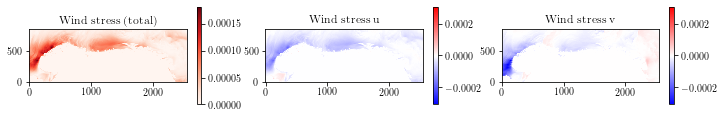

In [14]:
def animateWind(create_movie=True):
    wind_source = ic['wind_stress']
    
    max_stress = max(np.max(np.abs(wind_source.X)), np.max(np.abs(wind_source.Y)))
    wind_stress = np.sqrt(wind_source.X**2, wind_source.Y**2)

    fig = plt.figure(figsize=(12,3))
    
    ax = [None]*3
    sc = [None]*3
    
    ax[0] = plt.subplot(1,3,1)
    plt.title("Wind stress (total)")
    sc[0] = plt.imshow(wind_stress[0], origin='lower', vmin=0, cmap='Reds')
    plt.colorbar(shrink=0.6)

    ax[1] = plt.subplot(1,3,2)
    plt.title("Wind stress u")
    sc[1] = plt.imshow(wind_source.X[0], origin='lower', cmap='bwr', vmin=-max_stress, vmax=max_stress)
    plt.colorbar(shrink=0.6)

    ax[2] = plt.subplot(1,3,3)
    plt.title("Wind stress v")
    sc[2] = plt.imshow(wind_source.Y[0], origin='lower', cmap='bwr', vmin=-max_stress, vmax=max_stress)
    plt.colorbar(shrink=0.6)
    
    
    #Helper function which simulates and plots the solution
    def animate(i):
        fig.suptitle("Time = {:04.0f} h".format(time[i]/3600), fontsize=18)
        
        fig.sca(ax[0])
        sc[0].set_data(wind_stress[i])
        
        fig.sca(ax[1])
        sc[1].set_data(wind_source.X[i])
        
        fig.sca(ax[2])
        sc[2].set_data(wind_source.Y[i])

    #Matplotlib for creating an animation
    if (create_movie):
        anim = animation.FuncAnimation(fig, animate, range(len(time)), interval=250)
        plt.close(fig)
        return anim
    else:
        pass
    
animateWind(create_movie=create_movie)

(-2.5, 52.5, -0.8, 16.8)

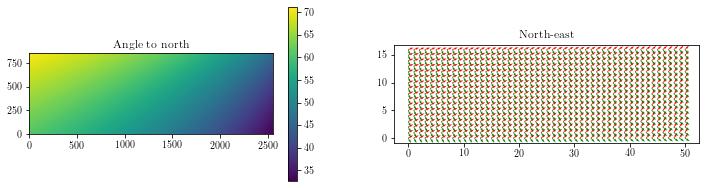

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Angle to north")
plt.imshow(ic['angle']*180/np.pi, origin='lower')
plt.axis('image')
plt.colorbar(shrink=0.4)

plt.subplot(1,2,2)
plt.title("North-east")
plt.quiver(np.sin(ic['angle'][::50, ::50]), np.cos(ic['angle'][::50, ::50]), color='r')
plt.quiver(np.cos(ic['angle'][::50, ::50]), -np.sin(ic['angle'][::50, ::50]), color='g')
plt.axis('image')

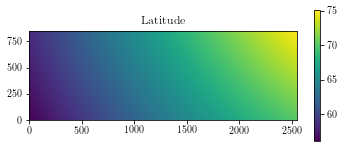

In [16]:
try:
    ncfile = Dataset(source_url)
    lat = ncfile.variables["lat"][y0:y1, x0:x1]
except Exception as e:
    raise e
finally:
    ncfile.close()
    
plt.figure()
plt.title("Latitude")
plt.imshow(lat, origin='lower')
plt.colorbar(shrink=0.6)

In [17]:
max_lat = np.max(lat)
min_lat = np.min(lat)
max_cor = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(max_lat))
min_cor = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(min_lat))
print("Max latitude: " + str(max_lat) + " => " + str(max_cor))
print("Min latitude: " + str(min_lat) + " => " + str(min_cor))

f, beta = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(lat[0, 0]))
print("F and beta are " + str([f, beta]))

Max latitude: 75.02715673393767 => [0.00014089042949755784, 5.914277335636927e-12]
Min latitude: 56.14792340020126 => [0.00012111864605220386, 1.2751730058827873e-11]
F and beta are [0.00012111864605220386, 1.2751730058827873e-11]


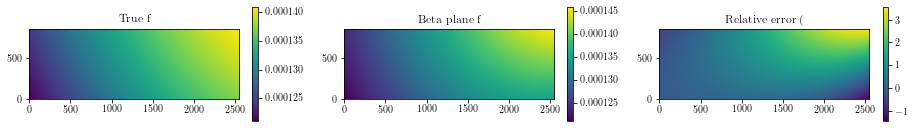

In [18]:
f_truth, _ = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(lat))

#Calculate beta plane approximation
YY, XX = np.mgrid[0:(y1-y0), 0:(x1-x0)]
XX = XX*ic['dx']
YY = YY*ic['dy']
local_lat = np.sin(ic['angle'])*XX + np.cos(ic['angle'])*YY
f_beta = f + beta*local_lat

plt.figure(figsize=(16, 3))
plt.subplot(1,3,1)
plt.title("True f")
plt.imshow(f_truth, origin='lower')#, vmin=-0.0002, vmax=0.0002)
plt.colorbar(shrink=0.7)


plt.subplot(1,3,2)
plt.title("Beta plane f")
plt.imshow(f_beta, origin='lower')#, vmin=-0.0002, vmax=0.0002)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,3)
plt.title("Relative error (%)")
plt.imshow(100*(f_beta-f_truth) / f_truth, origin='lower')#, vmin=-0.0001, vmax=0.0)
plt.colorbar(shrink=0.7)



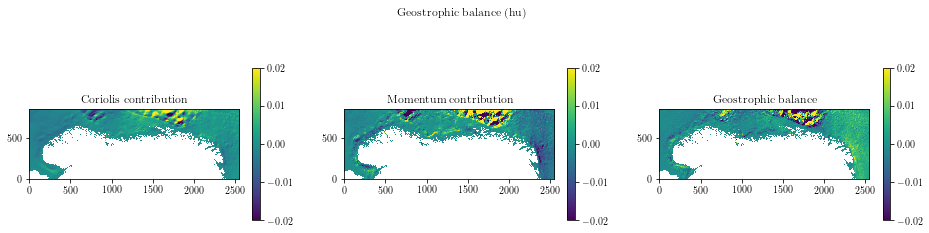

In [19]:
geos, geos_x, geos_y = OceanographicUtilities.calcGeostrophicBalance(
                            ic['eta0'], 
                            OceanographicUtilities.intersectionsToMidpoints(ic['H']), 
                            ic['hu0'], ic['hv0'], 
                            ic['angle'], f_beta,
                            ic['dx'], ic['dy'],
                            use_minmod=True)

plt.figure(figsize=(16,4))
plt.suptitle("Geostrophic balance (hu)")
plt.subplot(1,3,1)
plt.title("Coriolis contribution")
plt.imshow(geos_x[0], origin='lower', vmax=0.02, vmin=-0.02)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,2)
plt.title("Momentum contribution")
plt.imshow(geos_x[1], origin='lower', vmax=0.02, vmin=-0.02)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,3)
plt.title("Geostrophic balance")
plt.imshow(geos[0], origin='lower', vmax=0.02, vmin=-0.02)
plt.colorbar(shrink=0.7)

In [20]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar


def paperFig(eta, hu, hv, H_m, x, y, 
             interpolation="None", title=None, figsize=(9, 3.4),
             save_filename=None, main_title=None, savethis=False):
    
    fig, axs = plt.subplots(1,2, figsize=figsize)
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    clevels= np.arange(np.floor(eta.min()*5)/5, np.ceil(eta.max()*5)/5, 0.2)
    if x0 == case1_x0:
        clevels= np.arange(np.floor(eta.min()*10)/10, np.ceil(eta.max()*10)/10, 0.1)
        
    assert(len(clevels) < 51), 'clevels contains ' + str(len(clevels)) + ' levels!!'

    extent=np.array([0, x[-1], 0, y[-1]]) / 1000
    
    V = PlotHelper.genVelocity(eta + H_m, hu, hv)
    V.mask = H_m.mask
    
    # Colormaps
    eta_cmap = plt.cm.BrBG
    v_cmap=plt.cm.Oranges
    
    # Set land color
    #land_color = 'xkcd:grey green' # 'grey'
    land_color = 'grey'
    v_cmap.set_bad(land_color, alpha=1.0)
    eta_cmap.set_bad(land_color, alpha=1.0)
    
    # Specifying hard vlims
    eta_max = 2.1
    v_max = 0.42
    
    fontsize = 18
    if casename == 'complete_coast_':
        fontsize = 14
        main_title = main_title.replace('resolution', 'res.')
    def addColorbar(ax, im, title):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(title, fontsize=fontsize)
    
    eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', 
                           vmin=-eta_max, vmax=eta_max, extent=extent, cmap=eta_cmap) #GnBu')
    addColorbar(axs[0], eta_im, "$\eta$ [m]")
    eta_cs = axs[0].contour(eta, clevels, colors='k', origin='lower', corner_mask=True, linestyles='dashed', extent=extent)
    axs[0].clabel(eta_cs, eta_cs.levels, inline=True, fontsize=7, fmt='%1.1f', use_clabeltext=True)
    
    hv_im = axs[1].imshow(V, interpolation=interpolation, origin='lower',
                          vmin=0, vmax=v_max, extent=extent, cmap=v_cmap)
    addColorbar(axs[1], hv_im, "particle velocity [m/s]")
    
    
    
    if main_title is not None:
        axs[0].set_ylabel(main_title, labelpad=3, fontsize=fontsize)
    
    if title is not None:
        plt.suptitle(r"\textbf{"+title+"}", y=1.1) #, fontsize=14)
    
    if save_filename is not None and savethis:
        print(save_filename)
        fig.savefig(os.path.join(folder, save_filename + ".png"), bbox_inches='tight')
        fig.savefig(os.path.join(folder, save_filename + ".pdf"), bbox_inches='tight')
        plt.close()
        
        
def plotSingleReferenceStep(source_url, hour=-1, savethis=False):
    
    hour = hour%24
    save_filename = casename+'norkyst800_'+str(hour).zfill(2)
    title = 'NorKyst800 ' + str(hour)
    main_title = 'NorKyst800'
    
    ncfile = None
    try:
        ncfile = Dataset(source_url)
        H_m = ncfile.variables['h'][y0:y1, x0:x1]
        eta = ncfile.variables['zeta'][hour, y0:y1, x0:x1]
        hu = ncfile.variables['ubar'][hour, y0:y1, x0:x1]
        hv = ncfile.variables['vbar'][hour, y0:y1, x0:x1]
        
        x = ncfile.variables['X'][x0:x1]
        y = ncfile.variables['Y'][y0:y1]
        x = x - x[0]
        y = y - y[0]
        
        hu = hu * (H_m + eta)
        hv = hv * (H_m + eta)
        
    except Exception as e:
        raise e
    finally:
        ncfile.close()
        
    H_m.mask = eta.mask
    paperFig(eta, hu, hv, H_m, x, y,  title=title, main_title=main_title,
             save_filename=save_filename, savethis=savethis)
    
def plotSingleTimeStep(filename, main_title, hour=-1, savethis=False):
    
    hour = hour%24
    save_filename = filename.replace('.nc', '_'+str(hour).zfill(2))
    title = filename.replace('_', ' ').replace('.nc', ' ') + str(hour)
    filename = os.path.join(folder, filename)
    
    ncfile = None
    try:
        ncfile = Dataset(filename)

        x = ncfile.variables['x'][:]
        y = ncfile.variables['y'][:]
        t = ncfile.variables['time'][hour]

        H_m = ncfile.variables['Hm'][:,:]
        eta = ncfile.variables['eta'][hour,:,:]
        hu = ncfile.variables['hu'][hour,:,:]
        hv = ncfile.variables['hv'][hour,:,:]
    except Exception as e:
        raise e
    finally:
        if ncfile is not None:
            ncfile.close()
    
    if hour == 0:
        print('Info for ' + filename)
        print("shape Hm: ", H_m.shape)
        num_cells = H_m.shape[0]*H_m.shape[1]
        print("total number of cells ", num_cells)
        print("Dry cells, found by H_m.mask.sum(): ", H_m.mask.sum())
        print("Wet cells", num_cells - H_m.mask.sum())
        print("ratio of wet cells: ", str((num_cells - H_m.mask.sum())/num_cells))

    eta.mask = H_m.mask
    hu.mask = H_m.mask
    hv.mask = H_m.mask

    paperFig(eta, hu, hv, H_m, x, y,  title=title, main_title=main_title,
             save_filename=save_filename, savethis=savethis)
        
def randomtesting():
    test_ma = hu[:,:].copy()
    print(type(test_ma))
    fig = plt.figure(figsize=(6,4))
    cmap = plt.cm.viridis
    cmap.set_bad('white',1.)
    
    test_ma.mask = H_m.mask
    test_ma.data[test_ma.mask]=300

    
    plt.imshow(test_ma, origin='lower', cmap=cmap)
    plt.colorbar()
    print(test_ma.mask)
    print(H_m.min(), H_m.max(), np.sum(H_m.mask), H_m.shape[0]*H_m.shape[1])
    print(np.sum(test_ma.mask), test_ma.shape[0]*test_ma.shape[1])
    
    
    ### Test with contour plot for eta:
    fig = plt.figure(figsize=(6,4))
    
    eta_max = np.max(np.abs(eta))
    levels= np.arange(-eta_max, eta_max, 0.2)


    plt.imshow(eta, cmap='BrBG', origin='lower', vmin=-eta_max, vmax=eta_max)
    plt.contour(eta, levels, colors='k', origin='lower', corner_mask=True, linestyles='dashed')
    
    ### Test with contour plot for eta:
    fig = plt.figure(figsize=(6,4))
    
    eta_max = np.max(np.abs(eta))
    levels= np.arange(-np.ceil(eta_max), np.ceil(eta_max), 0.2)


    plt.imshow(eta, cmap='BrBG', origin='lower', vmin=-eta_max, vmax=eta_max)
    CS = plt.contour(eta, levels, colors='k', origin='lower', corner_mask=False, linestyles='dashed')
    plt.clabel(CS, CS.levels, inline=True, fontsize=9, fmt='%1.1f')

    
hour = 23
savethis = True
for hour in range(0,24, 6):
    plotSingleTimeStep(casename+'original.nc', 'Original resolution', 
                       hour=hour, savethis=savethis)
    plotSingleTimeStep(casename+'highres.nc', 'High resolution',
                       hour=hour, savethis=savethis)
    plotSingleTimeStep(casename+'lowres.nc',  'Low resolution',
                       hour=hour, savethis=savethis)
    plotSingleReferenceStep(source_url, 
                            hour=hour, savethis=savethis)

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/andreb/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-6abd2c3ea3ee>", line 191, in <module>
    hour=hour, savethis=savethis)
  File "<ipython-input-20-6abd2c3ea3ee>", line 126, in plotSingleTimeStep
    raise e
  File "<ipython-input-20-6abd2c3ea3ee>", line 115, in plotSingleTimeStep
    ncfile = Dataset(filename)
  File "netCDF4/_netCDF4.pyx", line 2291, in netCDF4._netCDF4.Dataset.__init__
  File "netCDF4/_netCDF4.pyx", line 1855, in netCDF4._netCDF4._ensure_nc_success
FileNotFoundError: [Errno 2] No such file or directory: b'complete_coast_2019_10_30/complete_coast_original.nc'
Popping <94300517736320>
Pushing <94300517736320>


FileNotFoundError: [Errno 2] No such file or directory: b'complete_coast_2019_10_30/complete_coast_original.nc'

In [ ]:
def plotAllStatistics(filenames, labels, single_figs=False):
    
    patterns = [':', '--', '-.']
    
    assert(len(filenames) == len(labels))

    if not single_figs:
        plt.figure(figsize=(6,2))

    for i in range(len(filenames)):
        filename = filenames[i]
        label = labels[i]
        pattern = patterns[i]
        
        if single_figs:
            plt.figure(figsize=(12,4))
    
        filename = os.path.join(folder, filename)
        try:
            ncfile = Dataset(filename)
            t = ncfile.variables['time'][:]
            num_iterations = ncfile.variables['num_iterations'][:]

            num_timesteps = len(t)
            max_abs_u = np.zeros(num_timesteps)
            max_abs_v = np.zeros(num_timesteps)

            H_m = ncfile.variables['Hm'][:,:]

            for i in range(num_timesteps):
                h = H_m + ncfile.variables['eta'][i,:,:]

                u = ncfile.variables['hu'][i,:,:] / h
                v = ncfile.variables['hv'][i,:,:] / h

                max_abs_u[i] = np.max(np.abs(u))
                max_abs_v[i] = np.max(np.abs(v))


        except Exception as e:
            print("Something went wrong:" + str(e))
            raise e
        finally:
            ncfile.close()

        #plt.title("Statistics")
        #plt.subplot(2,1,1)
        plt.plot(0.5*(t[1:] + t[:-1])/3600, np.diff(t)/np.diff(num_iterations), 
                 pattern, label=label)
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", 
               mode='expand', ncol=3)
    plt.ylim([0, 2])
    plt.grid()
    plt.xlabel('Time [hours]')
    plt.ylabel('$\Delta t$ [s]')
    
    plt.savefig(os.path.join(folder, 'adaptive_dt.pdf'), bbox_inches='tight')
    
    #plt.subplot(2,1,2)
    #plt.plot(t/3600, max_abs_u, label="Max $|u|$")
    #plt.plot(t/3600, max_abs_v, label="Max $|v|$")
    #plt.legend()
        
filenames = [casename+"original.nc",
             casename+"highres.nc",
             casename+"lowres.nc"]
labels = ['Original resolution', 
          'High resolution',
          'Low resolution']


plotAllStatistics(filenames, labels, single_figs=0)